In [1]:
import webbrowser
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Open the page so you can see it
url = "https://baseball.pointstreak.com/textstats/menu_games.html?seasonid=34122"
webbrowser.open(url)
print("Schedule page opened in your browser...")

# Strong User-Agent to make sure we get the real HTML table (not Markdown fallback)
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36"
})

response = session.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# Find the correct container and data table
container = soup.find("div", class_="menu_report_list")
data_table = container.find("table", class_="reports_table")

# Skip the header row → start from index 1
game_rows = data_table.find_all("tr")[1:]

print(f"\nFound {len(game_rows)} games. Extracting 3rd column (Away Team)...\n")
print("-" * 50)

away_teams = []

for i, row in enumerate(game_rows, 1):
    tds = row.find_all("td")
    if len(tds) < 5:  # safety check
        continue
    
    # Column index 2 = third column = Away Team
    away_team = tds[2].get_text(strip=True)
    away_teams.append(away_team)
    
    # Print first 10 so you see it working
    if i <= 10 or i > len(game_rows) - 5:
        print(f"Game {i:3d}: {away_team}")

# Show total
print("-" * 50)
print(f"Successfully scraped {len(away_teams)} away teams from the 3rd column!")
print(f"First 10: {away_teams[:10]}")
print(f"Last  5:  {away_teams[-5:]}")

# Optional: save to list or use later

Schedule page opened in your browser...

Found 202 games. Extracting 3rd column (Away Team)...

--------------------------------------------------
Game   1: Kitchener 6 @ Toronto 5
Game   2: London 6 @ Brantford 5
Game   3: Toronto 6 @ Barrie 4
Game   4: Brantford 8 @ Hamilton 9
Game   5: Guelph 0 @ London 7
Game   6: Barrie 3 @ Welland 9
Game   7: Kitchener 1 @ Chatham-Kent 9
Game   8: Guelph 1 @ Brantford 8
Game   9: Chatham-Kent 10 @ Kitchener 11
Game  10: London 12 @ Toronto 12
Game 198: Kitchener 6 @ Guelph 12
Game 199: Brantford 13 @ Toronto 14
Game 200: Hamilton 5 @ Brantford 6
Game 201: Welland 10 @ Kitchener 11
Game 202: London 4 @ Barrie 8
--------------------------------------------------
Successfully scraped 202 away teams from the 3rd column!
First 10: ['Kitchener 6 @ Toronto 5', 'London 6 @ Brantford 5', 'Toronto 6 @ Barrie 4', 'Brantford 8 @ Hamilton 9', 'Guelph 0 @ London 7', 'Barrie 3 @ Welland 9', 'Kitchener 1 @ Chatham-Kent 9', 'Guelph 1 @ Brantford 8', 'Chatham-Kent

In [2]:
game_results = pd.DataFrame(away_teams)
game_results.rename(columns={game_results.columns[0]: "Result"}, inplace=True)
game_results.head(2)

,Result
0,Kitchener 6 @ Toronto 5
1,London 6 @ Brantford 5


In [3]:
game_results[['AwayTeam', 'AwayRuns', 'HomeTeam', 'HomeRuns']] = game_results['Result'].str.extract(r'(.+?)\s+(\d*)\s*@\s*(.+?)\s+(\d*)')

game_results['AwayRuns'] = pd.to_numeric(game_results['AwayRuns'], errors='coerce')
game_results['HomeRuns'] = pd.to_numeric(game_results['HomeRuns'], errors='coerce')

In [4]:
game_results.head(2)

,Result,AwayTeam,AwayRuns,HomeTeam,HomeRuns
0,Kitchener 6 @ Toronto 5,Kitchener,6,Toronto,5
1,London 6 @ Brantford 5,London,6,Brantford,5


In [5]:
game_results = game_results.drop('Result', axis=1)
game_results.head(2)

,AwayTeam,AwayRuns,HomeTeam,HomeRuns
0,Kitchener,6,Toronto,5
1,London,6,Brantford,5


In [6]:
# Define your ballpark mapping
ballparks = {
    'Toronto':        'Dominico Field',
    'Brantford':      'Arnold Anderson Stadium',
    'Kitchener':      'Jack Couch Ball Park',
    'London':         'Labatt Park',
    'Barrie':         'Athletic Kulture Stadium',
    'Hamilton':       'Bernie Arbour Stadium',
    'Chatham-Kent':   'Fergie Jenkins Field',
    'Guelph':         'David E. Hastings Stadium',
    'Welland':        'Welland Stadium'
}

# ONE LINE → adds the Ballpark column perfectly!
game_results['Ballpark'] = game_results['HomeTeam'].map(ballparks)
game_results.head(2)

,AwayTeam,AwayRuns,HomeTeam,HomeRuns,Ballpark
0,Kitchener,6,Toronto,5,Dominico Field
1,London,6,Brantford,5,Arnold Anderson Stadium


In [7]:
game_results['GameRuns'] = game_results['HomeRuns'] + game_results['AwayRuns']
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Allow for full output width
pd.set_option('display.max_rows', None)  # Display all rows if necessary
game_results.head(2)

,AwayTeam,AwayRuns,HomeTeam,HomeRuns,Ballpark,GameRuns
0,Kitchener,6,Toronto,5,Dominico Field,11
1,London,6,Brantford,5,Arnold Anderson Stadium,11


In [8]:
game_results = game_results[game_results['GameRuns'] > 0]
game_results.head(2)

,AwayTeam,AwayRuns,HomeTeam,HomeRuns,Ballpark,GameRuns
0,Kitchener,6,Toronto,5,Dominico Field,11
1,London,6,Brantford,5,Arnold Anderson Stadium,11


In [9]:
park_summary = game_results.groupby('Ballpark').agg(
    Games=('GameRuns', 'count'),
    TotalRuns=('GameRuns', 'sum'),
    AvgRuns=('GameRuns', 'mean'),
    ParkFactor=('GameRuns', lambda x: (x.mean() / game_results['GameRuns'].mean() * 100).round(1))
).round(2)

# Sort from hitter-friendly to pitcher-friendly
park_summary = park_summary.sort_values('ParkFactor', ascending=False)

print(park_summary)

                           Games  TotalRuns  AvgRuns  ParkFactor
Ballpark                                                        
Jack Couch Ball Park          21        340    16.19       135.1
Dominico Field                21        339    16.14       134.7
Arnold Anderson Stadium       20        258    12.90       107.6
Fergie Jenkins Field          21        269    12.81       106.9
Welland Stadium               21        250    11.90        99.3
Athletic Kulture Stadium      21        227    10.81        90.2
David E. Hastings Stadium     21        199     9.48        79.1
Bernie Arbour Stadium         20        179     8.95        74.7
Labatt Park                   21        180     8.57        71.5


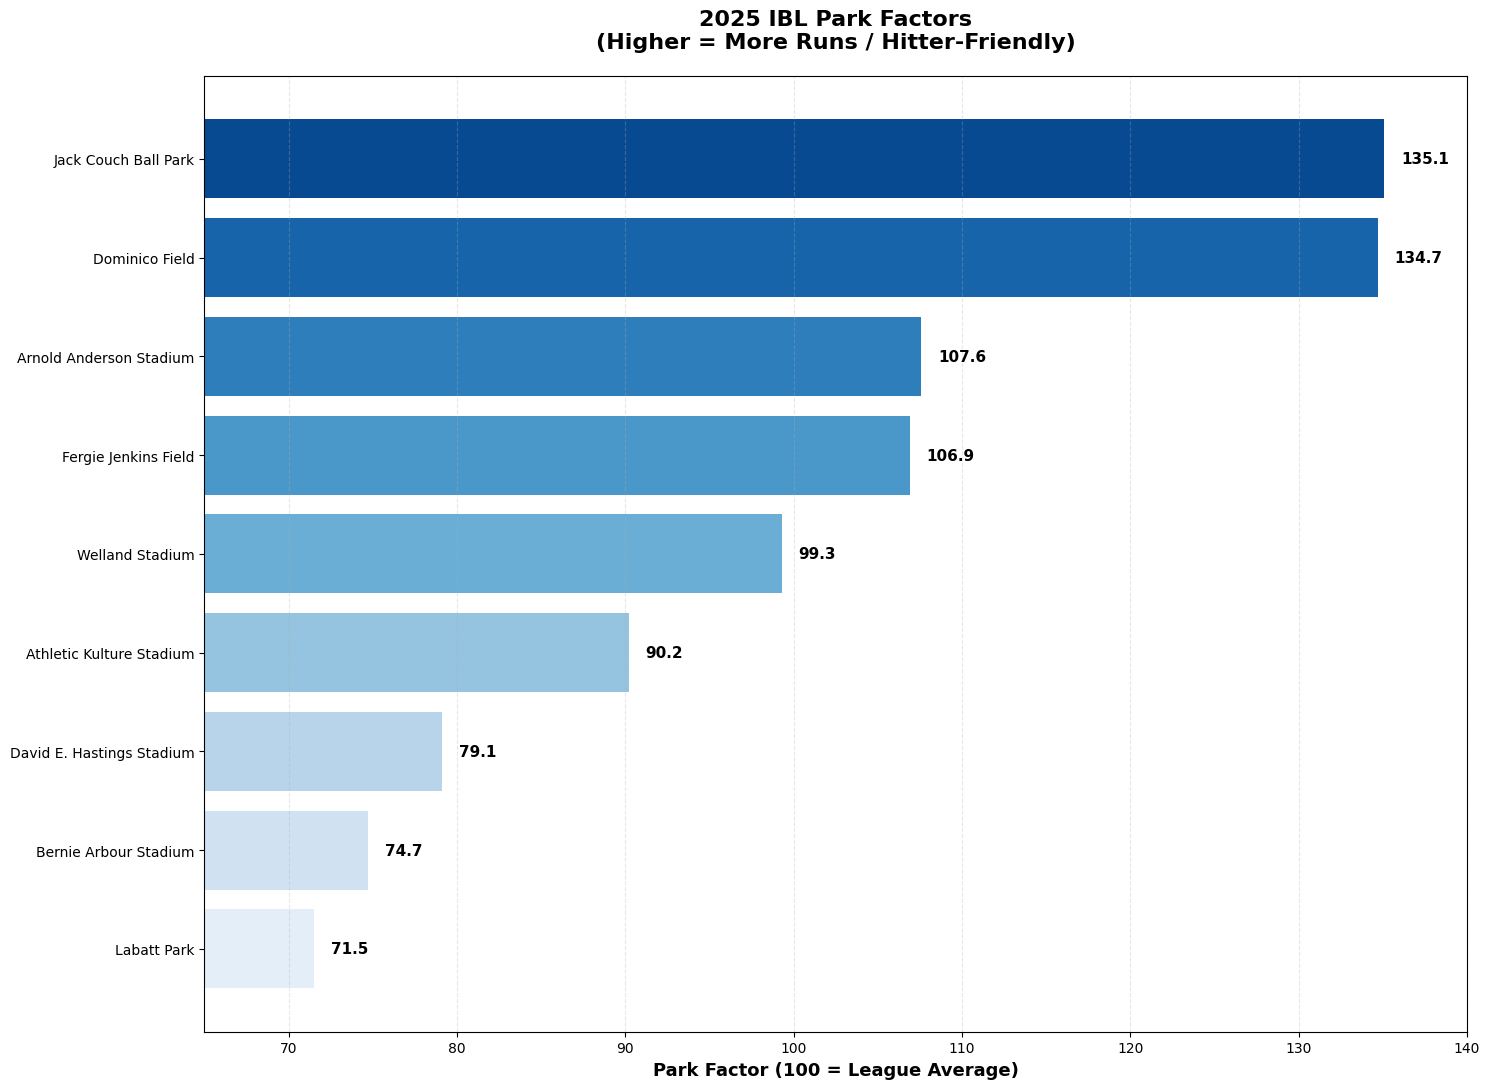

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Your data (without the Games column) ===
data = {
    'Ballpark': [
        'Jack Couch Ball Park', 'Dominico Field', 'Arnold Anderson Stadium',
        'Fergie Jenkins Field', 'Welland Stadium', 'Athletic Kulture Stadium',
        'David E. Hastings Stadium', 'Bernie Arbour Stadium', 'Labatt Park'
    ],
    'TotalRuns': [340, 339, 258, 269, 250, 227, 199, 179, 180],
    'AvgRuns': [16.19, 16.14, 12.90, 12.81, 11.90, 10.81, 9.48, 8.95, 8.57],
    'ParkFactor': [135.1, 134.7, 107.6, 106.9, 99.3, 90.2, 79.1, 74.7, 71.5]
}
df = pd.DataFrame(data)

# Sort by Park Factor (highest to lowest)
df = df.sort_values('ParkFactor', ascending=True)

# === Create the plot ===
plt.figure(figsize=(15, 11))
colors = sns.color_palette("Blues", len(df))
bars = plt.barh(df['Ballpark'], df['ParkFactor'], color=colors)

# Customize appearance
plt.xlabel('Park Factor (100 = League Average)', fontsize=13, fontweight='bold')
plt.title('2025 IBL Park Factors\n(Higher = More Runs / Hitter-Friendly)', 
          fontsize=16, fontweight='bold', pad=20)

# Add value labels on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', 
             va='center', ha='left', fontsize=11, fontweight='bold')

# Light grid for readability
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.xlim(65, 140)

# Clean layout
plt.tight_layout()

# Optional: save as high-quality PNG for blog
plt.savefig('IBL_2025_Park_Factors.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()